In [ ]:
import os
import random
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt


from matplotlib.pyplot import imshow
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model, load_model

Criando a lista de categorias. Para isso vamos ler o conteudo da pasta dataset-foguetes, cada pasta é uma categoria


In [ ]:
root = './dataset_foguetes'
train_split, val_split = 0.7, 0.15
#categories = [pasta for pasta in os.listdir(root) if os.path.isdir(os.path.join(root, pasta))]
categories = [x[0] for x in os.walk(root) if x[0]][1:]
print(categories)

['./dataset_foguetes/proton', './dataset_foguetes/.ipynb_checkpoints', './dataset_foguetes/soyuz']


In [ ]:
#Carregar as imagens das pastas que foram localizadas
# função auxiliar para carregar a imagem e retorná-la e inserir o vetor
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames
              in os.walk(category) for f in filenames
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})

# comtar o número de classes
num_classes = len(categories)

criar divisão de treinamento/validação/teste (70%, 15%, 15%)

In [ ]:
random.shuffle(data)
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

In [ ]:
#separar dados e labels
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[2, 2, 0, 0, 0]


Pré-processe os dados como antes, certificando-se de que sejam float32 e normalizados entre 0 e 1.

In [ ]:
# normalizar dados
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# converter rótulos em vetores one-hot
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(5, 3)


In [ ]:
#Resumo das informações que temos até o momento
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)

finished loading 30 images from 3 categories
train / validation / test split: 21, 4, 5
training data shape:  (21, 224, 224, 3)
training labels shape:  (21, 3)


Se tudo funcionou corretamente, você deve ter carregado várias imagens e elas foram divididas em três conjuntos: train, val e test. A forma dos dados de treinamento deve ser (n, 224, 224, 3) onde n é o tamanho do seu conjunto de treinamento e os rótulos devem ser (n, c) onde c é o número de classes (97 no caso de 101_Categorias de objetos.

Observe que dividimos todos os dados em três subconjuntos – um conjunto de treinamento (train), um conjunto de validação (val) e um conjunto de testes (test). A razão para isso é avaliar adequadamente a precisão do nosso classificador. Durante o treinamento, o otimizador utiliza o conjunto de validação para avaliar seu desempenho interno, a fim de determinar o gradiente sem sobreajuste ao conjunto de treinamento (overfitting). O conjunto de teste é sempre retirado do algoritmo de treinamento e só é usado no final para avaliar a precisão final do nosso modelo.

Vejamos alguns exemplos de imagens de nosso conjunto de dados.

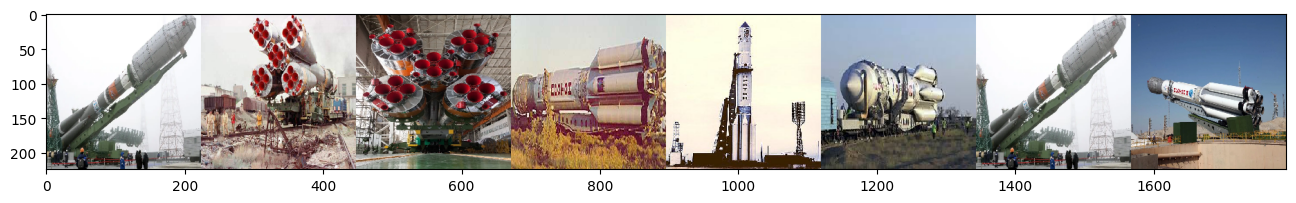

In [ ]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

Vamos construir uma rede neural do zero para fazer a classificação em nosso conjunto de dados.

A rede que construiremos contém 4 camadas alternadas convolucionais e de pooling máximo, seguidas por um dropout após cada outro par conv/pooling. Após a última camada de pooling, anexaremos uma camada totalmente conectada com 256 neurônios, outra camada de dropout e, finalmente, uma camada de classificação softmax para nossas classes.

Nossa função de perda será, como sempre, perda categórica de entropia cruzada (categorical cross-entropy loss), e nosso algoritmo de aprendizagem será AdaDelta. Várias coisas nesta rede podem ser alteradas para obter melhor desempenho, talvez usar uma rede maior ou um otimizador diferente ajude, mas para os propósitos deste notebook, o objetivo é apenas obter uma compreensão de uma linha de base aproximada para fins de comparação, e portanto não é necessário gastar muito tempo tentando otimizar esta rede.

Ao compilar a rede, vamos executar model.summary() para obter um instantâneo de suas camadas.


In [ ]:
# Nome do arquivo do modelo salvo
model_path = 'meu_modelo.keras'
compilar_modelo = False
if os.path.exists(model_path):
   # Carregar o modelo salvo
   model = load_model(model_path)
   print("Modelo carregado a partir do arquivo.")
else:
  # construindo a rede
  compilar_modelo = True
  model = Sequential()
  print("Input dimensions: ",x_train.shape[1:])

  model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(32, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Dropout(0.25))

  model.add(Conv2D(32, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(32, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(256))
  model.add(Activation('relu'))

  model.add(Dropout(0.5))

  model.add(Dense(num_classes))
  model.add(Activation('softmax'))

  model.summary()

Modelo carregado a partir do arquivo.


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 14 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Criamos uma rede de tamanho médio com aproximadamente 1,2 milhão de pesos e tendências (os parâmetros). A maioria deles está levando a uma camada totalmente conectada pré-softmax "dense_5".

Agora podemos prosseguir e treinar nosso modelo para 10 épocas com um tamanho de lote de 128. Também registraremos seu histórico para que possamos representar graficamente a perda ao longo do tempo mais tarde.

In [ ]:
if (compilar_modelo):
  # compilar o modelo para usar a função de perda de entropia cruzada categórica e o otimizador adadelta
  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

  history = model.fit(x_train, y_train,
                      batch_size=128,
                      epochs=10,
                      validation_data=(x_val, y_val))

  # Salvar o modelo treinado
  model.save(model_path)
  print("Modelo salvo no arquivo.")


Vamos representar graficamente a perda de validação e a precisão da validação ao longo do tempo.

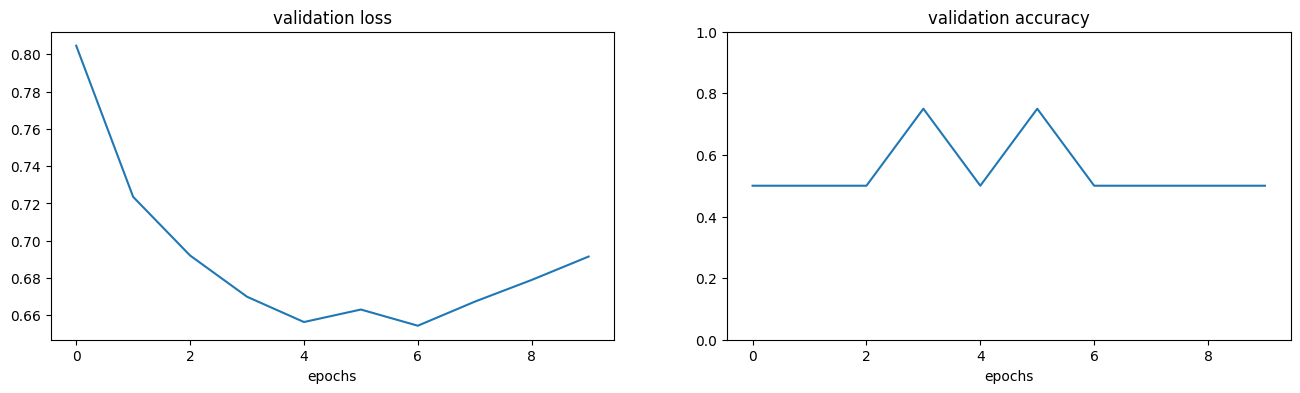

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

Vamos obter uma avaliação final executando nosso modelo no conjunto de treinamento. Fazendo isso, obtemos os seguintes resultados:

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.7797584533691406
Test accuracy: 0.4000000059604645


Finalmente, vemos que alcançamos uma precisão (top-1) de cerca de 40%. Isso não é tão ruim para 6.000 imagens, considerando que se usássemos uma estratégia ingênua de fazer suposições aleatórias, teríamos obtido apenas cerca de 1% de precisão.

Para prever uma nova imagem, basta executar o código a seguir para obter as probabilidades de cada classe.

In [ ]:
img, x = get_image('./teste1.jpg')
probabilities = model.predict([x])
print(probabilities)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
[[0. 0. 1.]]


In [ ]:
import numpy as np

# Encontrando o índice da maior probabilidade
classe_predita = np.argmax(probabilities)

print(f"A classe predita é: {classe_predita}")

A classe predita é: 2


In [ ]:
print(num_classes)
print(categories)
# Nomes das classes (substitua pelos nomes reais das suas classes)
class_names = ['Classe 1', 'Classe 2', 'Classe 3']

# Iterando sobre as probabilidades e exibindo o nome da classe e sua probabilidade
for prob, class_name in zip(probabilities[0], class_names):
    print(f"{class_name}: {prob * 100:.2f}%")

3
['./dataset_foguetes/proton', './dataset_foguetes/.ipynb_checkpoints', './dataset_foguetes/soyuz']
Classe 1: 0.00%
Classe 2: 0.00%
Classe 3: 100.00%


In [ ]:
img, x = get_image('./teste2.jpg')
probabilities2 = model.predict([x])
print(probabilities2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
[[1.0000000e+00 0.0000000e+00 2.7131932e-24]]


In [ ]:
img, x = get_image('./teste3.jpg')
probabilities3 = model.predict([x])
print(probabilities3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[[0. 0. 1.]]
